In [1]:
import cnn_builder as cbuild
import config
import copy
import glob
import importlib
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.masks as masks
import numpy as np
import os
import shutil
from os.path import *
%matplotlib inline
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_dilation
from skimage.morphology import ball, label

import numpy as np
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import np_utils

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [94]:
importlib.reload(hf)
C = config.Config()

In [3]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

## CT, Lipiodol seg

In [82]:
importlib.reload(masks)

<module 'niftiutils.masks' from 'c:\\users\\clinton\\documents\\niftiutils\\niftiutils\\masks.py'>

In [108]:
def seg_liver(ct_img, save_folder, ct_dims):
    B3 = ball(3)
    B3 = B3[:,:,[0,2,3,4,6]]
    #B3 = ball(4)
    #B3 = B3[:,:,[1,3,5,6,8]]
    orig_shape = ct_img.shape

    x = tr.apply_window(ct_img)
    x -= np.amin(x)

    crops = list(map(int,[.05 * x.shape[0], .95 * x.shape[0]] + \
                    [.05 * x.shape[1], .95 * x.shape[1]] + \
                    [.05 * x.shape[2], .95 * x.shape[2]]))
    
    x = x[crops[0]:crops[1], crops[2]:crops[3], crops[4]:crops[5]]
    scale_shape = x.shape
    x, _ = tr.rescale_img(x, C.dims)
    
    y = model.predict(np.expand_dims(x,0))[0]
    liver_mask = (y[:,:,:,1] > y[:,:,:,0]).astype(float)
    liver_mask, _ = tr.rescale_img(liver_mask, scale_shape)#orig_shape)
    liver_mask = np.pad(liver_mask, ((crops[0], orig_shape[0]-crops[1]),
                                     (crops[2], orig_shape[1]-crops[3]),
                                     (crops[4], orig_shape[2]-crops[5])), 'constant')

    liver_mask = binary_opening(binary_closing(liver_mask, B3, 2), B3, 2)
    labels, num_labels = label(liver_mask, return_num=True)
    label_sizes = [np.sum(labels == label_id) for label_id in range(1,num_labels+1)]
    biggest_label = label_sizes.index(max(label_sizes))+1
    liver_mask[labels != biggest_label] = 0
    
    masks.save_mask(liver_mask, join(save_folder, "liver_pred"), ct_dims, save_mesh=True)

In [12]:
info = {}

for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        
    seg_liver(ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims)
    break

In [88]:
def seg_lipiodol(img, save_folder, ct_dims):
    low_mask = copy.deepcopy(img)
    low_mask = low_mask > 100
    low_mask = binary_opening(binary_closing(low_mask, structure=np.ones((2,2,1))), structure=np.ones((2,2,1)))
    mid_mask = copy.deepcopy(img)
    mid_mask = mid_mask > 150
    mid_mask = binary_closing(mid_mask)
    high_mask = copy.deepcopy(img)
    high_mask = high_mask > 200
    
    masks.save_mask(low_mask, join(save_folder, "low_lipiodol"), ct_dims, save_mesh=True)
    masks.save_mask(mid_mask, join(save_folder, "mid_lipiodol"), ct_dims, save_mesh=True)
    masks.save_mask(high_mask, join(save_folder, "high_lipiodol"), ct_dims, save_mesh=True)

In [102]:
info = {}

for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    seg_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    break

## Non-target Lipiodol seg

In [132]:
def seg_target_lipiodol(img, save_folder, ct_dims, num_tumors=1):
    mid_mask = copy.deepcopy(img)
    mid_mask = mid_mask > 150
    mid_mask = binary_closing(mid_mask)
    
    mask1 = copy.deepcopy(img)
    mask1 = mask1 > 150
    B2 = ball(2)
    B2 = B2[:,:,[0,2,4]]
    mask1 = binary_dilation(mask1, np.ones((3,3,1)))
    
    if num_tumors == 1:
        tumor_labels, num_labels = label(mask1, return_num=True)
        label_sizes = [np.sum(tumor_labels == label_id) for label_id in range(1,num_labels+1)]
        biggest_label = label_sizes.index(max(label_sizes))+1
        mask1[tumor_labels != biggest_label] = 0
    
    mask1 = binary_opening(binary_closing(mask1, structure=B2, iterations=2), structure=B2, iterations=2)
    
    if num_tumors == 1:
        tumor_labels, num_labels = label(mask1, return_num=True)
        label_sizes = [np.sum(tumor_labels == label_id) for label_id in range(1,num_labels+1)]
        biggest_label = label_sizes.index(max(label_sizes))+1
        mask1[tumor_labels != biggest_label] = 0
    
    target_mask = mask1 * mid_mask
    nontarget_mask = (1-mask1) * mid_mask
    
    masks.save_mask(mask1, join(save_folder, "tumor_pred"), ct_dims, save_mesh=True)
    masks.save_mask(target_mask, join(save_folder, "target_lip"), ct_dims, save_mesh=True)
    masks.save_mask(nontarget_mask, join(save_folder, "nontarget_lip"), ct_dims, save_mesh=True)

In [ ]:
info = {}

for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    if dirname(seg) in info.keys():
        (ct_img, ct_dims, mask) = info[dirname(seg)]
    else:
        ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
        mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)
        
    seg_target_lipiodol((mask > 0) * ct_img, dirname(seg), ct_dims)
    info[dirname(seg)] = (ct_img, ct_dims, mask)
    #break

### other CT

In [73]:
src_dir = r"C:\Users\Clinton\Downloads\24h CT tumor segmentions (Milena's data)"

In [75]:
for seg in glob.glob(join(src_dir,"tumor 24h_*")):
    patient_id = seg[seg.rfind('_Pat')+4:seg.rfind('.')]
    if len(patient_id) == 1:
        patient_id = "0"+patient_id
    dest = join(target_dir, patient_id)
    #if not exists(join(dest,basename(seg))):
    shutil.move(seg, dest)
    #print(seg, dest)

In [6]:
for ctfolder in glob.glob(join(target_dir,"*","CT24h")):
    os.rename(ctfolder, join(dirname(ctfolder), "CT24h"))

In [ ]:
for seg in glob.glob(join(target_dir,"*","*CT*")):
    contents = os.listdir(seg)
    filterstr = ' 1 5 '
    target_folder = [x for x in contents if filterstr in x]
    others = [x for x in contents if filterstr not in x]
    if len(target_folder) == 1:
        for o in others:
            shutil.rmtree(join(seg, o))

# UNet

In [77]:
importlib.reload(config)
C = config.Config()

In [92]:
seg = glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids"))[0]

In [93]:
ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)

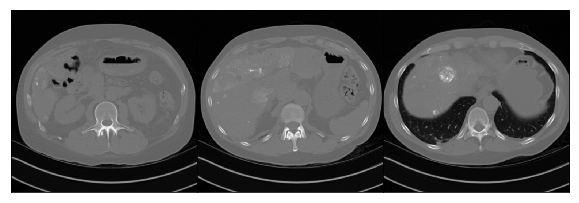

In [102]:
hf.draw_slices(ct_img[:,:,:])

In [ ]:
lesion_id = "07"
glob.glob(join(target_dir,lesion_id,"CT24h","*"))

In [27]:
for f in glob.glob(join(target_dir,lesion_id,"CT24h","*")):
    if "5 0" not in f:
        shutil.rmtree(f)
    else:
        shutil.move()

In [59]:
import random
random.uniform()

In [58]:
lesion_id

'17'

In [57]:
train_set = []
for seg in glob.glob(join(target_dir,"*","liver bl*.ids")):
    lesion_id = dirname(seg)[-2:]
    if exists(join(C.full_img_dir, lesion_id+"_mri.npy")):
        #train_set.append([np.load(join(C.full_img_dir, lesion_id+"_ct.npy")),
        #                  np.load(join(C.full_img_dir, lesion_id+"_mask.npy")),
        #                  lesion_id])
        continue
    
    mri_img, mri_dims = hf.nii_load(join(dirname(seg), "CT24h"), True, True)
    mask, _ = masks.get_mask(seg, ct_dims, mri_img.shape)

    mri_img = tr.apply_window(mri_img)
    mri_img -= np.amin(mri_img)
    
    np.save(join(C.full_img_dir, lesion_id+"_mri.npy"), ct_img)
    np.save(join(C.full_img_dir, lesion_id+"_mr_liver_mask.npy"), mask > 128)

In [ ]:
train_set = []
for seg in glob.glob(join(target_dir,"*","wholeliver_24hCT*.ids")):
    lesion_id = dirname(seg)[-2:]
    if exists(join(C.full_img_dir, lesion_id+"_ct.npy")):
        #train_set.append([np.load(join(C.full_img_dir, lesion_id+"_ct.npy")),
        #                  np.load(join(C.full_img_dir, lesion_id+"_mask.npy")),
        #                  lesion_id])
        continue
    
    ct_img, ct_dims = hf.dcm_load(join(dirname(seg), "CT24h"), True, True)
    mask, _ = masks.get_mask(seg, ct_dims, ct_img.shape)

    ct_img = tr.apply_window(ct_img)
    ct_img -= np.amin(ct_img)
    
    np.save(join(C.full_img_dir, lesion_id+"_ct.npy"), ct_img)
    np.save(join(C.full_img_dir, lesion_id+"_mask.npy"), mask > 128)

In [91]:
importlib.reload(cbuild)
model = cbuild.build_ct_unet()
model.summary(120)

<module 'cnn_builder' from 'C:\\Users\\Clinton\\Documents\\Lipiodol\\cnn_builder.py'>

In [92]:
hist = model.fit_generator(cbuild.train_gen(), epochs=100, steps_per_epoch=50)

Epoch 1/100
100/100 [==============================] - 54s 542ms/step - loss: 0.4683 - acc: 0.8901
Epoch 2/100
100/100 [==============================] - 45s 453ms/step - loss: 0.2272 - acc: 0.9801
Epoch 3/100
100/100 [==============================] - 45s 455ms/step - loss: 0.1185 - acc: 0.9849
Epoch 4/100
100/100 [==============================] - 45s 452ms/step - loss: 0.0734 - acc: 0.9867
Epoch 5/100
100/100 [==============================] - 46s 456ms/step - loss: 0.0533 - acc: 0.9873
Epoch 6/100
100/100 [==============================] - 46s 460ms/step - loss: 0.0445 - acc: 0.9876
Epoch 7/100
100/100 [==============================] - 46s 459ms/step - loss: 0.0371 - acc: 0.9887
Epoch 8/100
100/100 [==============================] - 46s 459ms/step - loss: 0.0338 - acc: 0.9888
Epoch 9/100
100/100 [==============================] - 46s 460ms/step - loss: 0.0298 - acc: 0.9897
Epoch 10/100
100/100 [==============================] - 46s 463ms/step - loss: 0.0280 - acc: 0.9899
Epoch 11/

100/100 [==============================] - 47s 469ms/step - loss: 0.0143 - acc: 0.9937
Epoch 84/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0144 - acc: 0.9937
Epoch 85/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0132 - acc: 0.9942
Epoch 86/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0139 - acc: 0.9939
Epoch 87/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0137 - acc: 0.9940
Epoch 88/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0140 - acc: 0.9939
Epoch 89/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0127 - acc: 0.9944
Epoch 90/100
100/100 [==============================] - 47s 469ms/step - loss: 0.0139 - acc: 0.9939
Epoch 91/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0137 - acc: 0.9940
Epoch 92/100
100/100 [==============================] - 47s 470ms/step - loss: 0.0139 - acc: 0.9939
Epoch 93/100


In [38]:
model.save(join(C.model_dir, "train17.hdf5"))

In [107]:
lesion_id = "18"
ct_img, ct_dims = hf.dcm_load(join(target_dir, lesion_id, "CT24h"), True, True)
seg_liver(ct_img, join(target_dir, lesion_id), ct_dims)